# **Machine Learning Project**

**Burak Arslan (13022067)** \
**Timo Büscher (13977776)** \
**Lars Hissink (13998080)** \
**Miras Kanatzhanov (13075012)**

# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# **Loading the Data**

In [ ]:
# First, we need to give acces to Colab to our GoogleDrive
# More info how to connect datasets downloaded on our shared GoogleDrive:
# https://saturncloud.io/blog/how-to-import-files-from-google-drive-to-colab/

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Demographics dataset
# As this dataset is not organized, we put it in alphabetic order for the column 'gm_naam' to make it easier to clean

df_1 = pd.read_excel('/content/drive/MyDrive/Machine_Learning_Project/CBS and second dataset/Demographics dataset.xlsx')
df_1

In [ ]:
# Health dataset
# We also sort this dataset and put it in alphabetic order for the column 'Gemeentenaam_1'

df_2 = pd.read_excel('/content/drive/MyDrive/Machine_Learning_Project/CBS and second dataset/Health dataset.xlsx')
df_2

,ID,Leeftijd,Marges,WijkenEnBuurten,Perioden,Gemeentenaam_1,SoortRegio_2,Codering_3,ErvarenGezondheidGoedZeerGoed_4,VoldoetAanBeweegrichtlijn_5,...,ErnstigZeerErnstigEenzaam_28,EmotioneelEenzaam_29,SociaalEenzaam_30,Mantelzorger_31,Vrijwilligerswerk_32,MoeiteMetRondkomen_33,LopenEnOfFietsenNaarSchoolOfWerk_34,LopenNaarSchoolOfWerk_35,FietsenNaarSchoolOfWerk_36,NietSpecifiekeKlachten_37
0,24603,20300,MW00000,GM0518,2022JJ00,'s-Gravenhage,Gemeente,GM0518,64.1,48.6,...,20.7,39.5,44.1,11.9,18.2,30.8,.,.,.,59.6
1,25011,20300,MW00000,BU05183131,2022JJ00,'s-Gravenhage,Buurt,BU05183131,63.7,50.3,...,22.8,44.2,47.6,9.9,13.8,36.5,.,.,.,58.4
2,25007,20300,MW00000,BU05183130,2022JJ00,'s-Gravenhage,Buurt,BU05183130,63.4,48.1,...,21.7,41.7,46.1,10.7,14.7,34.9,.,.,.,59.3
3,25003,20300,MW00000,WK051831,2022JJ00,'s-Gravenhage,Wijk,WK051831,62.9,48.7,...,23.1,44.3,48.1,10.3,14.0,36.9,.,.,.,58.8
4,24999,20300,MW00000,BU05183034,2022JJ00,'s-Gravenhage,Buurt,BU05183034,54.2,44.1,...,28.2,49.0,54.5,11.0,11.6,46.0,.,.,.,62.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17998,71739,20300,MW00000,WK019314,2022JJ00,Zwolle,Wijk,WK019314,71.4,51.3,...,14.2,31.2,32.3,11.4,28.6,23.0,.,.,.,53.3
17999,71735,20300,MW00000,BU01931360,2022JJ00,Zwolle,Buurt,BU01931360,73.8,51.9,...,12.8,29.5,32.4,12.4,29.4,16.7,.,.,.,52.9
18000,71731,20300,MW00000,BU01931350,2022JJ00,Zwolle,Buurt,BU01931350,73.7,51.2,...,12.3,26.7,32.3,21.0,28.6,17.8,.,.,.,54.5
18001,71819,20300,MW00000,BU01932260,2022JJ00,Zwolle,Buurt,BU01932260,76.9,48.8,...,12.0,26.1,29.0,11.3,32.0,18.4,.,.,.,50.0


In [ ]:
# Average demographic and health metrics across the Netherlands

nl_1 = df_1.loc[df_1['recs'] == 'Land']
df_2['SoortRegio_2'] = df_2['SoortRegio_2'].apply(lambda x: x.strip())
nl_2 = df_2.loc[df_2['SoortRegio_2'] == 'Land']
nl = pd.merge(nl_1, nl_2, left_on='recs', right_on='SoortRegio_2', how='inner')
columns_drop = ['gwb_code_8', 'gwb_code_10', 'gwb_code', 'ind_wbi', 'ID', 'Leeftijd', 'Marges', 'WijkenEnBuurten', 'Perioden', 'Gemeentenaam_1', 'SoortRegio_2', 'Codering_3']
nl.drop(columns_drop , inplace=True, axis=1)
for col in nl.loc[:, 'a_inw':]:
    if nl[col].dtype == 'object':
        nl[col] = pd.to_numeric(nl[col], errors='coerce')
miss = nl.columns[nl.isnull().any()]
nl.drop(miss, inplace=True, axis=1)


In [ ]:
# We merge two datasets
# We clear Key Columns in both tables of any whitespace

df_1['gwb_code'] = df_1['gwb_code'].apply(lambda x: x.strip())
df_2['WijkenEnBuurten'] = df_2['WijkenEnBuurten'].apply(lambda x: x.strip())
df = pd.merge(df_1, df_2, left_on='gwb_code', right_on='WijkenEnBuurten', how='inner')

In [ ]:
# We check whether the neighborhoods in both datasets match in the same index and same municipality name

df.loc[:, ['gm_naam', 'Gemeentenaam_1', 'gwb_code', 'WijkenEnBuurten']]

,gm_naam,Gemeentenaam_1,gwb_code,WijkenEnBuurten
0,'s-Gravenhage,'s-Gravenhage,BU05182917,BU05182917
1,'s-Gravenhage,'s-Gravenhage,BU05181785,BU05181785
2,'s-Gravenhage,'s-Gravenhage,BU05181786,BU05181786
3,'s-Gravenhage,'s-Gravenhage,BU05181795,BU05181795
4,'s-Gravenhage,'s-Gravenhage,WK051818,WK051818
...,...,...,...,...
17997,Zwolle,Zwolle,BU01931400,BU01931400
17998,Zwolle,Zwolle,WK019314,WK019314
17999,Zwolle,Zwolle,BU01931360,BU01931360
18000,Zwolle,Zwolle,BU01932280,BU01932280


# **Data Preprocessing**

In [ ]:
df.shape

(18002, 162)

Unrefined merged DataFrame consists out of 162 columns and 18002 rows.

In [ ]:
df.columns

Index(['gwb_code_10', 'gwb_code_8', 'regio', 'gm_naam', 'recs', 'gwb_code',
       'ind_wbi', 'a_inw', 'a_man', 'a_vrouw',
       ...
       'ErnstigZeerErnstigEenzaam_28', 'EmotioneelEenzaam_29',
       'SociaalEenzaam_30', 'Mantelzorger_31', 'Vrijwilligerswerk_32',
       'MoeiteMetRondkomen_33', 'LopenEnOfFietsenNaarSchoolOfWerk_34',
       'LopenNaarSchoolOfWerk_35', 'FietsenNaarSchoolOfWerk_36',
       'NietSpecifiekeKlachten_37'],
      dtype='object', length=162)

In [ ]:
# We determine the columns that present no predictive information for the research such as ID
# We delete such columns from the dataset

columns_useless = ['gwb_code_8', 'gwb_code_10', 'gwb_code', 'ind_wbi', 'ID', 'Leeftijd', 'Marges', 'WijkenEnBuurten', 'Perioden', 'Gemeentenaam_1', 'SoortRegio_2', 'Codering_3']
df.drop(columns_useless, inplace=True, axis=1)

# We also delete columns that show multicollinearity with the target variable for example 'underweight'

columns_multicollinear = ['Ondergewicht_7', 'NormaalGewicht_8', 'Overgewicht_9']
df.drop(columns_multicollinear, inplace=True, axis=1)

# We filter the neighborhoods since we only want to observe the effects in 'Buurt' which by definition is the smallest neighborhood type in the dataset

nl_average =  df.loc[df['recs'] == 'Land']
df = df.loc[df['recs'] == 'Buurt']
df

,regio,gm_naam,recs,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,...,ErnstigZeerErnstigEenzaam_28,EmotioneelEenzaam_29,SociaalEenzaam_30,Mantelzorger_31,Vrijwilligerswerk_32,MoeiteMetRondkomen_33,LopenEnOfFietsenNaarSchoolOfWerk_34,LopenNaarSchoolOfWerk_35,FietsenNaarSchoolOfWerk_36,NietSpecifiekeKlachten_37
0,Schildersbuurt-Oost,'s-Gravenhage,Buurt,6805,3360,3445,1280,1090,1750,1850,...,31.9,52.4,57.1,13.1,12.9,53.5,.,.,.,68.6
1,Kerketuinen en Zichtenburg,'s-Gravenhage,Buurt,135,115,25,5,20,55,50,...,34.7,58.5,57.9,8.2,17.3,52.0,.,.,.,61.3
2,Houtwijk,'s-Gravenhage,Buurt,12750,6255,6490,2110,1350,2965,3515,...,16.5,32.8,40.1,14.0,18.9,26.9,.,.,.,59.9
3,Kom Loosduinen,'s-Gravenhage,Buurt,5055,2315,2745,610,375,1190,1275,...,18.8,36.7,41.8,13.8,17.5,28.7,.,.,.,62.3
5,Waldeck-Zuid,'s-Gravenhage,Buurt,2050,910,1140,275,140,385,565,...,19.0,37.8,43.5,14.0,17.9,29.1,.,.,.,64.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,Veerallee,Zwolle,Buurt,1900,965,940,420,330,470,460,...,9.4,23.4,26.1,13.2,37.2,12.9,.,.,.,49.7
17997,Kamperpoort,Zwolle,Buurt,2250,1125,1130,155,360,945,380,...,17.6,36.9,36.7,10.1,22.4,30.3,.,.,.,55.9
17999,Hanzeland,Zwolle,Buurt,1105,575,530,80,185,365,270,...,12.8,29.5,32.4,12.4,29.4,16.7,.,.,.,52.9
18000,Stadsbroek,Zwolle,Buurt,60,30,30,5,15,10,15,...,7.2,20.7,28.1,14.8,39.9,9.8,.,.,.,50.4


In [ ]:
df.dtypes

regio                                  object
gm_naam                                object
recs                                   object
a_inw                                   int64
a_man                                   int64
                                        ...  
MoeiteMetRondkomen_33                  object
LopenEnOfFietsenNaarSchoolOfWerk_34    object
LopenNaarSchoolOfWerk_35               object
FietsenNaarSchoolOfWerk_36             object
NietSpecifiekeKlachten_37              object
Length: 147, dtype: object

In [ ]:
# As the dataframe is simplified, we convert the numerical datatypes into floats

for col in df.loc[:, 'a_inw':]:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
df.dtypes

regio                                   object
gm_naam                                 object
recs                                    object
a_inw                                    int64
a_man                                    int64
                                        ...   
MoeiteMetRondkomen_33                  float64
LopenEnOfFietsenNaarSchoolOfWerk_34    float64
LopenNaarSchoolOfWerk_35               float64
FietsenNaarSchoolOfWerk_36             float64
NietSpecifiekeKlachten_37              float64
Length: 147, dtype: object

In [ ]:
# We get the columns with missing values and impute them with the mean

missing = df.columns[df.isnull().any()]
df[missing] = df[missing].fillna(df[missing].mean())

In [ ]:
#If the column is missing all the values, then we drop it from the dataframe

missing = df.columns[df.isnull().any()]
df.drop(missing, inplace=True, axis=1)
df

,regio,gm_naam,recs,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,...,HoogRisicoOpAngstOfDepressie_25,HeelVeelStressInAfgelopen4Weken_26,Eenzaam_27,ErnstigZeerErnstigEenzaam_28,EmotioneelEenzaam_29,SociaalEenzaam_30,Mantelzorger_31,Vrijwilligerswerk_32,MoeiteMetRondkomen_33,NietSpecifiekeKlachten_37
0,Schildersbuurt-Oost,'s-Gravenhage,Buurt,6805,3360,3445,1280,1090,1750,1850,...,25.5,35.4,70.9,31.9,52.4,57.1,13.1,12.9,53.5,68.6
1,Kerketuinen en Zichtenburg,'s-Gravenhage,Buurt,135,115,25,5,20,55,50,...,27.9,36.0,74.2,34.7,58.5,57.9,8.2,17.3,52.0,61.3
2,Houtwijk,'s-Gravenhage,Buurt,12750,6255,6490,2110,1350,2965,3515,...,11.6,22.0,53.3,16.5,32.8,40.1,14.0,18.9,26.9,59.9
3,Kom Loosduinen,'s-Gravenhage,Buurt,5055,2315,2745,610,375,1190,1275,...,12.6,22.1,56.4,18.8,36.7,41.8,13.8,17.5,28.7,62.3
5,Waldeck-Zuid,'s-Gravenhage,Buurt,2050,910,1140,275,140,385,565,...,12.2,21.1,58.4,19.0,37.8,43.5,14.0,17.9,29.1,64.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,Veerallee,Zwolle,Buurt,1900,965,940,420,330,470,460,...,7.6,18.9,40.0,9.4,23.4,26.1,13.2,37.2,12.9,49.7
17997,Kamperpoort,Zwolle,Buurt,2250,1125,1130,155,360,945,380,...,15.2,26.4,53.9,17.6,36.9,36.7,10.1,22.4,30.3,55.9
17999,Hanzeland,Zwolle,Buurt,1105,575,530,80,185,365,270,...,9.6,20.2,47.8,12.8,29.5,32.4,12.4,29.4,16.7,52.9
18000,Stadsbroek,Zwolle,Buurt,60,30,30,5,15,10,15,...,5.0,13.6,38.7,7.2,20.7,28.1,14.8,39.9,9.8,50.4


# **Data Understanding**

In [ ]:
# We describe the target value of overweight in the dataframe

df.loc[:,['ErnstigOvergewicht_10']].describe()

,ErnstigOvergewicht_10
count,14317.000000
mean,15.690783
std,3.497178
min,5.100000
25%,13.300000
50%,15.600000
75%,17.700000
max,38.300000


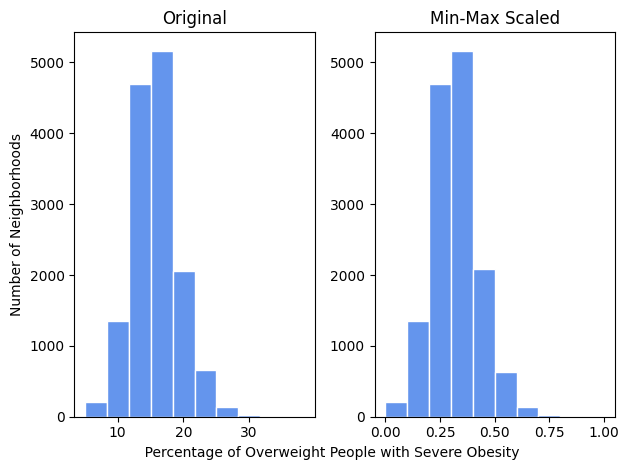

In [ ]:
figure, axis = plt.subplots(1, 2)
axis[0].hist(df['ErnstigOvergewicht_10'], bins=10, edgecolor='white', color='cornflowerblue')
axis[0].set_title("Original")
scaled_data=MinMaxScaler().fit_transform(df[['ErnstigOvergewicht_10']])
axis[1].hist(scaled_data, bins=10, edgecolor='white', color='cornflowerblue')
axis[1].set_title("Min-Max Scaled")
axis[0].set(ylabel='Number of Neighborhoods')
axis[0].set(xlabel='                                                               Percentage of Overweight People with Severe Obesity')
plt.tight_layout()
plt.show()

With Min-Max normalization all features are transformed into the range [0,1] meaning that the minimum and maximum value of a variable is going to be 0 and 1, respectively.

# **Data Partitioning**

In [ ]:
X = df.loc[:,df.columns!='ErnstigOvergewicht_10' ]
X = X.loc[:, 'a_inw':]
y = df[['ErnstigOvergewicht_10']]

For the exploratory data analysis we will use 93 independent variables, 1 target varable and 14317 observations.

In [ ]:
# Test size is 20% and train size is 80%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **OLS Regression**

In [ ]:
pipe_minmax = Pipeline([('scaler',  MinMaxScaler()), ('regressor', LinearRegression())])
pipe_minmax.fit(X_train, y_train).score(X_test, y_test)
pipe_minmax.fit(X_train, y_train)
y_predict = pipe_minmax.fit(X_train, y_train).predict(X_test)
print("Train set score (R^2): {:.3f}".format(pipe_minmax.fit(X_train, y_train).score(X_train, y_train)))
print("Test set score (R^2): {:.3f}".format(pipe_minmax.fit(X_train, y_train).score(X_test, y_test)))
print("MSE: {:.3f}".format(np.square(np.subtract(y_test.to_numpy(),y_predict)).mean()))
print("MAE: {:.3f}".format(mae(y_test,y_predict)))

Train set score (R^2): 0.880
Test set score (R^2): -40.528
MSE: 512.162
MAE: 1.268


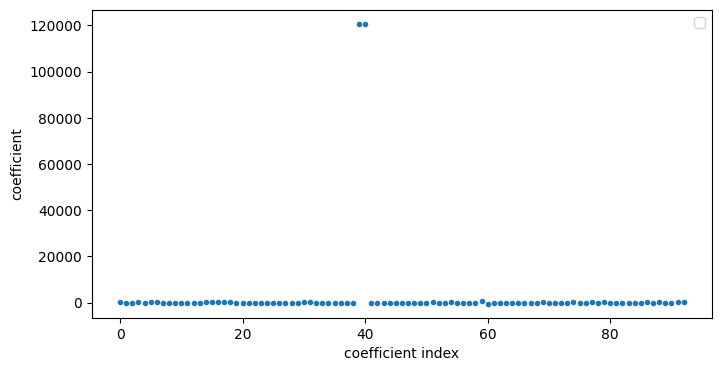

In [ ]:
pipe_minmax.fit(X_train, y_train)
plt.figure(figsize=(8, 4))
plt.plot(pipe_minmax.named_steps['regressor'].coef_[0], '.')
plt.ylabel("coefficient")
plt.xlabel("coefficient index")
plt.legend()

In [ ]:
feature_names = X_train.columns
coefficients = pipe_minmax.named_steps['regressor'].coef_[0]
intercept = pipe_minmax.named_steps['regressor'].intercept_
sorted_coeffs = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)
print(f'Intercept: {intercept}')
print('Top 5 Coefficients (Descending Order):')
for i, (name, coef) in enumerate(sorted_coeffs[:5]):
    print(f'{i + 1}. Coefficient for {name}: {coef}')

Intercept: [-120708.77809901]
Top 5 Coefficients (Descending Order):
1. Coefficient for p_bjo2k: 120731.72127742025
2. Coefficient for p_bjj2k: 120731.35445668241
3. Coefficient for a_opp_ha: 532.5842035345879
4. Coefficient for a_lan_ha: -526.0451764220265
5. Coefficient for a_pau: 179.77205182712325


# **Ridge Regression**

In [ ]:
pipe_minmax = Pipeline([('scaler',  MinMaxScaler()), ('regressor', Ridge())])
pipe_minmax.fit(X_train, y_train).score(X_test, y_test)
pipe_minmax.fit(X_train, y_train)
y_predict = pipe_minmax.fit(X_train, y_train).predict(X_test)
print("Train set score (R^2): {:.3f}".format(pipe_minmax.fit(X_train, y_train).score(X_train, y_train)))
print("Test set score (R^2): {:.3f}".format(pipe_minmax.fit(X_train, y_train).score(X_test, y_test)))
print("MSE: {:.3f}".format(np.square(np.subtract(y_test.to_numpy(),y_predict)).mean()))
print("MAE: {:.3f}".format(mae(y_test,y_predict)))

Train set score (R^2): 0.878
Test set score (R^2): 0.883
MSE: 1.438
MAE: 0.848


In [ ]:
pipe=Pipeline([("scaler", MinMaxScaler()), ("ridge", Ridge())])
param_grid = {'ridge__alpha': np.logspace(-5, 9, 30)}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test)))
print("MSE: {:.3f}".format(np.square(np.subtract(y_test.to_numpy(),y_predict)).mean()))
print("MAE: {:.3f}".format(mae(y_test,y_predict)))
print("Best parameter {}".format(grid.best_params_))

Best cross-validation accuracy: 0.876
Test set score: 0.883
MSE: 1.438
MAE: 0.848
Best parameter {'ridge__alpha': 0.07278953843983153}


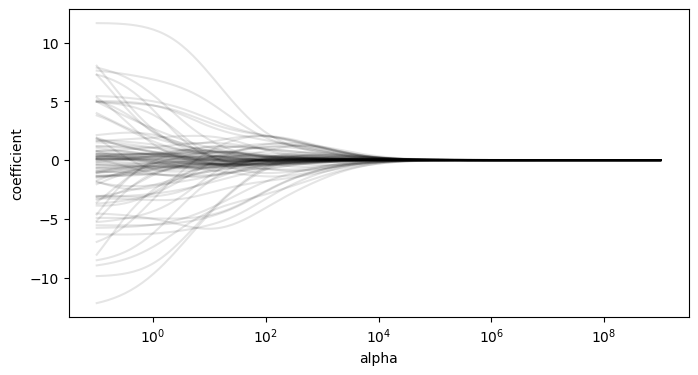

In [ ]:
#Graph that shows the relation between alphas and coefficients
n_alphas = 200
alphas = np.logspace(-1, 9, n_alphas)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

plt.figure(figsize=(8, 4))
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)
coefs = np.array(coefs).squeeze()
plt.plot(alphas, coefs, c='k', alpha=0.1)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("coefficient")
plt.show()

# **Lasso Regression**

In [ ]:
#Pipeline for minmax scaled data
pipe=Pipeline([("scaler", MinMaxScaler()), ("lasso", Lasso(max_iter=1000, tol=0.0001))])
param_grid = {'lasso__alpha': np.logspace(-5, 0, 30, base = 3)}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
y_predict = grid.fit(X_train, y_train).predict(X_test)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Scaled Train set score: {:.3f}".format(grid.score(X_train, y_train)))
print("Scaled Test set score: {:.3f}".format(grid.score(X_test, y_test)))
print("Scaled MSE: {:.3f}".format(np.square(np.subtract(y_test.to_numpy(),y_predict)).mean()))
print("Scaled MAE: {:.3f}".format(mae(y_test,y_predict)))
print("Best parameter {}".format(grid.best_params_))

Best cross-validation accuracy: 0.858
Scaled Train set score: 0.859
Scaled Test set score: 0.867
Scaled MSE: 22.187
Scaled MAE: 0.916
Best parameter {'lasso__alpha': 0.00411522633744856}


In [ ]:
#Lasso regression for unscaled data
warnings.simplefilter('ignore')
lasso_reg = Lasso(max_iter=1000, tol=0.0001).fit(X_train, y_train)
param_grid = {'alpha': np.logspace(-5, 0, 30, base=3)}

grid = GridSearchCV(lasso_reg, param_grid, return_train_score=True, cv= 5)
best_alpha = grid.fit(X_train, y_train).best_params_['alpha']
print("Optimal 'alpha': ", best_alpha)

y_predict_las = Lasso(best_alpha).fit(X_train, y_train).predict(X_test)
y_predict_las = y_predict_las.reshape(2864,1)
print("Uncaled Train set score (R^2): {:.3f}".format(Lasso(best_alpha).fit(X_train, y_train).score(X_train, y_train)))
print("Uncaled Test set score (R^2): {:.3f}".format(Lasso(best_alpha).fit(X_train, y_train).score(X_test,y_test)))
print("Uncaled MSE: {:.3f}".format(mse(y_test, y_predict_las)))
print("Uncaled MAE: {:.3f}".format(mae(y_test, y_predict_las)))

Optimal 'alpha':  0.004973430022703658
Uncaled Train set score (R^2): 0.880
Uncaled Test set score (R^2): 0.884
Uncaled MSE: 1.436
Uncaled MAE: 0.845


Text(0, 0.5, 'score')

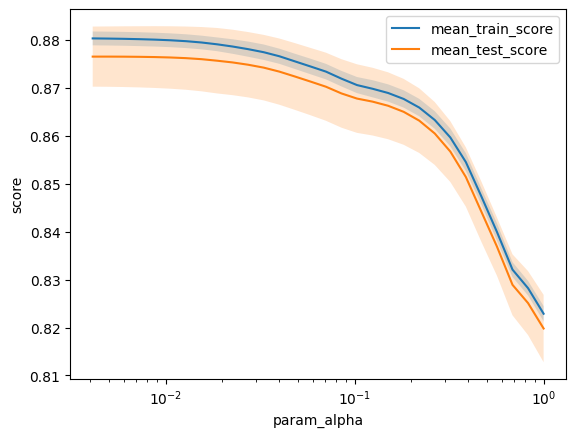

In [ ]:
#Validation Curve
results = pd.DataFrame(grid.fit(X_train, y_train).cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")
plt.ylabel("score")

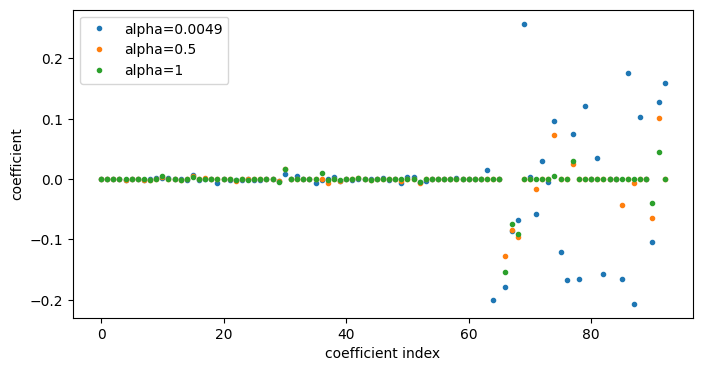

In [ ]:
#Value of coefficients and the coefficient index
lasso0049 = Lasso(alpha=0.0049).fit(X_train, y_train)
lasso05 = Lasso(alpha=0.5).fit(X_train, y_train)
lasso1 = Lasso(alpha=1).fit(X_train, y_train)

plt.figure(figsize=(8, 4))
plt.plot(lasso0049.coef_, '.', label="alpha=0.0049")
plt.plot(lasso05.coef_, '.', label="alpha=0.5")
plt.plot(lasso1.coef_, '.', label="alpha=1")

plt.ylabel("coefficient")
plt.xlabel("coefficient index")
plt.legend()

Text(0, 0.5, 'R^2')

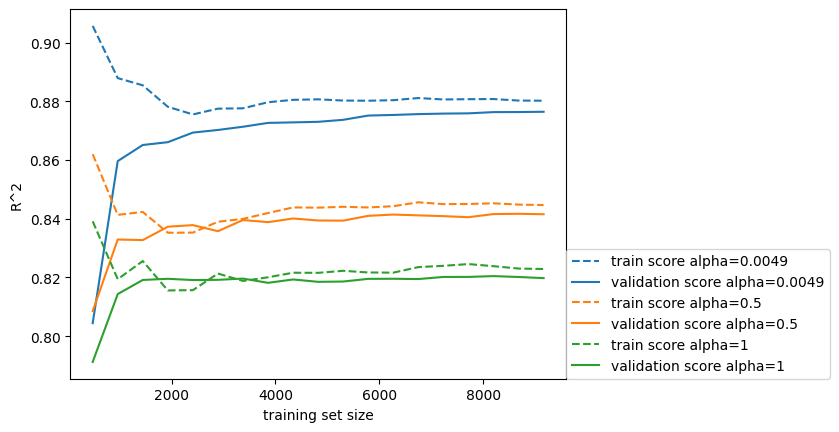

In [ ]:
#Learning Curve
def plot_learning_curve(est, name):
    train_set_size, train_scores, test_scores = learning_curve(est, X_train, y_train, cv=5, train_sizes=np.linspace(0, 1, 20)[1:])
    test_mean = test_scores.mean(axis=1)
    train_mean = train_scores.mean(axis=1)
    line, = plt.plot(train_set_size, train_mean, linestyle="--", label="train score {}".format(name))
    plt.plot(train_set_size, test_mean, label="validation score {}".format(name),
             c=line.get_color())
plot_learning_curve(Lasso(alpha=0.0049), "alpha=0.0049")
plot_learning_curve(Lasso(alpha=0.5), "alpha=0.5")
plot_learning_curve(Lasso(alpha=1), "alpha=1")
plt.legend(loc=(1, 0))
plt.xlabel("training set size")
plt.ylabel("R^2")

# **Random Forest Regression**

Random Forest algorithm is unaffected by the scale of numerical input variables, so we dont use Min-Max here

In [ ]:
np.random.seed(228)
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=2, random_state=228, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
rf_r_b = rf_random.best_estimator_
y_predict = rf_r_b.predict(X_test)
r2 = r2_score(y_test, y_predict)
print("Test set score (R^2): {:.3f}".format(r2))
print("MSE: {:.3f}".format(mse(y_test, y_predict)))
print("MAE: {:.3f}".format(mae(y_test, y_predict)))

Test set score (R^2): 0.891
MSE: 1.341
MAE: 0.813
